# TREE CALIBRATION - Cálculo de Constantes Finales

Este notebook demuestra el **proceso completo de calibración** usando el sistema Tree.

## 🎯 Objetivo: CALCULAR constantes de calibración

### 🌳 ROOT = Set 57 (R3)

**ROOT = Referencia absoluta del laboratorio**
- Todos los caminos de calibración terminan en el ROOT
- Set 57 es el ROOT porque contiene la referencia patrón del lab
- No tiene raised (no necesita calibrarse con nadie)

```
Jerarquía:
Set 57 (R3) ← ROOT ★ (referencia absoluta)
    ↑
Set 49 (R2) ← Intermedia
    ↑
Set 3,4,5... (R1) ← Base (sensores a calibrar)
```

---

### Diferencia con TREE.ipynb:
- **TREE.ipynb**: Muestra la ARQUITECTURA (TreeEntry + Tree)
  - Cómo crear Tree vacío
  - Cómo añadir TreeEntries
  - Cómo visualizar estructura con `print(tree)`
  - Especificar qué sets explorar
  
- **Este notebook (TREE_CALIBRATION)**: USA el Tree para CALCULAR constantes
  - Búsqueda de múltiples caminos R1 → R2 → R3 (ROOT)
  - Media ponderada con 1/σ²
  - Constantes finales para todos los sensores

---

## Proceso de calibración:

1. **Construcción del Tree** con todos los CalibSets
2. **Búsqueda de caminos** múltiples R1 → R2 → R3 (ROOT)
3. **Media ponderada** usando 1/σ² como peso
4. **Constantes finales** para todos los sensores

## Concepto: Múltiples Caminos hacia ROOT

```
Sensor 48060 (Set 3, R1) puede llegar al ROOT (Set 57, R3) por:

Camino 1: 48060 → 48203 (R1→R2) → 48484 (R2→R3) → ROOT ✓
Camino 2: 48060 → 48203 (R1→R2) → 48747 (R2→R3) → ROOT ✓
Camino 3: 48060 → 48479 (R1→R2) → 48484 (R2→R3) → ROOT ✓
Camino 4: 48060 → 48479 (R1→R2) → 48747 (R2→R3) → ROOT ✓

Cada camino da un offset diferente → Media ponderada = mejor precisión
```

## 1. Setup e Imports

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Añadir src al path
project_root = Path.cwd().parent
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Imports del proyecto - Clases principales
from tree_entry import TreeEntry
from tree import Tree
from calibset import CalibSet
from logfile import Logfile

# Imports de utils - Funciones
from utils.config import load_config
from utils.set_utils import create_calibration_set
from utils.tree_utils import create_tree_from_calibsets
from utils.calibration_utils import (
    calibrate_tree,
    find_all_paths_to_reference,
    weighted_average_paths,
    export_calibration_details
)

print("[OK] Imports completados")
print(f"  Project root: {project_root}")
print(f"  Src path: {src_path}")

[OK] Imports completados
  Project root: /Users/vicky/Desktop/rtd-calib-desde0/RTD_Calibration
  Src path: /Users/vicky/Desktop/rtd-calib-desde0/RTD_Calibration/src


## 2. Cargar Configuración

In [2]:
config_path = project_root / 'config' / 'config.yml'
config = load_config(str(config_path))

print("[OK] Configuración cargada:")
print(f"  Total sets: {len(config['sensors']['sets'])}")

# Contar por rondas
rounds_count = {}
for set_info in config['sensors']['sets'].values():
    try:
        r = int(set_info['round'])
        rounds_count[r] = rounds_count.get(r, 0) + 1
    except (ValueError, KeyError):
        continue

print(f"\n  Distribución por rondas:")
for r in sorted(rounds_count.keys()):
    print(f"    R{r}: {rounds_count[r]} sets")

[OK] Configuración cargada:
  Total sets: 60

  Distribución por rondas:
    R1: 48 sets
    R2: 8 sets
    R3: 2 sets
    R4: 1 sets


## 3. Crear TODOS los CalibSets

⚠️ **Esto puede tardar varios minutos** dependiendo del número de sets y runs.

### 📝 Nota sobre "Referencia interna"

**¿Qué es la referencia que se muestra al crear CalibSets?**

Cuando ves:
```
Set 3.0: 12 sensores creados
  Referencia: 48060
```

Esto es la **referencia INTERNA del CalibSet**, NO la referencia absoluta del lab.

**Cómo se elige**:
- Se toma el **primer sensor** de la lista `sensors` en el `config.yml` para ese set
- Ejemplo Set 3: `sensors: [48060, 48061, 48062, ...]` → referencia = **48060**
- Es **fija** desde el config, no se cambia después

**¿Para qué sirve?**:
- **Solo para cálculos INTERNOS** del CalibSet (dentro del set)
- Todos los offsets del Set 3 se calculan respecto a 48060
- Formato: `offset(sensor) = temperatura(sensor) - temperatura(48060)`

**Diferencia con RAISED**:
| Concepto | Referencia Interna (48060) | Raised (48203, 48479) |
|----------|---------------------------|----------------------|
| Ámbito | **Solo dentro del Set 3** | **Conecta con rondas superiores** |
| Propósito | Base para offsets internos | Permite caminos R1 → R2 → R3 |
| Uso en Tree | **No se usa** | **Sí se usa** (clave del sistema) |
| Cambia | No, es fijo | No, está en config |

**En resumen**:
- **Referencia interna = 48060**: Solo para cálculos dentro del Set 3
- **Raised = 48203, 48479**: Conectan el Set 3 con Set 49 (R2)
- **ROOT = Set 57**: Referencia absoluta del laboratorio (final de todos los caminos)

La referencia interna es **temporal** y solo matemática. Los raised son los que realmente **importan** para la calibración Tree.

### ⚠️ Nota sobre Set 55

El Set 55 **anteriormente fallaba** con un error `KeyError: Timestamp(...)` en el run 4.

**Causa**: `pandas.loc[t0:t1]` requiere que `t0` exista exactamente en el índice. Si no existe, falla.

**Solución aplicada**: Cambio a máscara booleana en `utils.py`:
```python
# Antes (fallaba):
window = run.temperatures.loc[t0:t1]

# Ahora (funciona):
mask = (run.temperatures.index >= t0) & (run.temperatures.index <= t1)
window = run.temperatures[mask]
```

**Impacto**: Solo 1 de 229 runs tenía este problema. El cambio es seguro y no afecta al resto.

In [3]:
import time

# Cargar logfile
logfile_relative = config['paths']['logfile']
if logfile_relative.startswith('RTD_Calibration/'):
    logfile_relative = logfile_relative.replace('RTD_Calibration/', '', 1)
logfile_path = project_root / logfile_relative

logfile_obj = Logfile(filepath=str(logfile_path))
logfile_df = logfile_obj.log_file
print(f"[OK] Logfile cargado: {len(logfile_df)} entradas\n")

calibsets = {}
failed_sets = []

print("Creando CalibSets...")
print("=" * 60)

start_time = time.time()

for set_id in sorted(config['sensors']['sets'].keys()):
    try:
        # create_calibration_set devuelve (calibset, mean_offsets, std_offsets)
        calibset, _, _ = create_calibration_set(
            set_number=set_id,
            logfile=logfile_df,
            config=config
        )
        calibsets[set_id] = calibset
        
        # Log cada 10 sets
        if len(calibsets) % 10 == 0:
            elapsed = time.time() - start_time
            print(f"  Procesados: {len(calibsets)} sets ({elapsed:.1f}s)")
    
    except Exception as e:
        failed_sets.append((set_id, str(e)))
        # No imprimir errores de sets sin datos (R4, etc)
        if "No temperature data" not in str(e):
            print(f"  [FAIL] Set {set_id}: {e}")

elapsed = time.time() - start_time

print("\n" + "=" * 60)
print(f"[OK] CalibSets creados: {len(calibsets)}")
print(f"[INFO] Sets sin datos: {len(failed_sets)}")
print(f"Tiempo: {elapsed:.1f}s")

if failed_sets and len(failed_sets) < 10:
    print("\nSets con errores:")
    for set_id, error in failed_sets[:5]:
        print(f"  Set {set_id}: {error[:60]}...")


CSV file loaded successfully from '/Users/vicky/Desktop/rtd-calib-desde0/RTD_Calibration/data/LogFile.csv'.
[OK] Logfile cargado: 832 entradas

Creando CalibSets...
[OK] Set 3.0: 12 sensores creados
  Referencia: 48060 (canal 1)
  Procesando 4 runs válidos...
  [OK] Cargado 20220531_ln2_r48176_r48177_48060_48479_7: 821 registros, 14 canales
  [OK] Cargado 20220531_ln2_r48176_r48177_48060_48479_8: 2260 registros, 14 canales
  [OK] Cargado 20220531_ln2_r48176_r48177_48060_48479_9: 794 registros, 14 canales
  [OK] Cargado 20220531_ln2_r48176_r48177_48060_48479_10: 680 registros, 14 canales
  [OK] 4 runs válidos con offsets
  [OK] Estadísticas calculadas: 12/12 sensores
[OK] Set 4.0: 12 sensores creados
  Referencia: 48480 (canal 1)
  Procesando 4 runs válidos...
  [OK] Cargado 20220607_ln2_r48176_r48177_48480-48491_1: 985 registros, 14 canales
  [OK] Cargado 20220607_ln2_r48176_r48177_48480-48491_2: 1286 registros, 14 canales
  [OK] Cargado 20220607_ln2_r48176_r48177_48480-48491_3: 1127 r

## 4. Crear Tree Completo

### 📊 Nota sobre "X offsets calculados"

Cuando construyes el Tree verás mensajes como:
```
Set 3.0 (R1): 2 raised, 18 offsets calculados
Set 5.0 (R1): 2 raised, 20 offsets calculados
```

**¿De dónde sale ese número?**

El total de offsets = suma de offsets para cada raised:

```python
Para Set 3:
  - 12 sensores totales
  - 2 descartados (48205, 48478) → quedan 10 válidos
  - Para raised 48203: 10 - 1 (sí mismo) = 9 offsets
  - Para raised 48479: 10 - 1 (sí mismo) = 9 offsets
  - TOTAL: 9 + 9 = 18 offsets ✓
```

**Variabilidad (18, 20, 22)**:
- Depende del número de **descartados** por set
- Set con 0 descartados → 22 offsets
- Set con 1 descartado → 20 offsets  
- Set con 2 descartados → 18 offsets

El número refleja los offsets **realmente útiles** para construir caminos R1 → R2 → R3.

In [ ]:
print("Construyendo Tree...")

tree = create_tree_from_calibsets(
    calibsets=calibsets,
    config=config,
    root_set_id=57.0  # Set 57 es R3 (root)
)

print("\n✓ Tree construido:")
print(f"  Total entries: {len(tree.entries)}")
# set_number viene del CalibSet, no del TreeEntry directamente
print(f"  Root: Set {tree.root.calibset.set_number if tree.root else 'N/A'}")

# Estadísticas por ronda (calculadas dinámicamente por BFS)
print("\n  Entries por ronda:")
for r in [1, 2, 3]:
    entries = tree.get_entries_by_round(r)
    print(f"    R{r}: {len(entries)} entries")

print("\nEstructura del Tree:")
print(tree)


Construyendo Tree...
Construyendo Tree desde 60 CalibSets...
  Set 3.0: 2 discarded
  Set 4.0: 2 discarded
  Set 5.0: 1 discarded
  Set 6.0: 2 discarded
  Set 7.0: 3 discarded
  Set 8.0: 2 discarded
  Set 9.0: 0 discarded
  Set 10.0: 0 discarded
  Set 11.0: 0 discarded
  Set 13.0: 0 discarded
  Set 14.0: 3 discarded
  Set 15.0: 2 discarded
  Set 16.0: 2 discarded
  Set 17.0: 2 discarded
  Set 18.0: 1 discarded
  Set 19.0: 1 discarded
  Set 20.0: 0 discarded
  Set 21.0: 2 discarded
  Set 22.0: 2 discarded
  Set 23.0: 4 discarded
  Set 24.0: 1 discarded
  Set 25.0: 2 discarded
  Set 26.0: 3 discarded
  Set 27.0: 3 discarded
  Set 28.0: 2 discarded
  Set 29.0: 1 discarded
  Set 30.0: 3 discarded
  Set 31.0: 1 discarded
  Set 32.0: 1 discarded
  Set 33.0: 1 discarded
  Set 34.0: 0 discarded
  Set 35.0: 3 discarded
  Set 36.0: 1 discarded
  Set 37.0: 2 discarded
  Set 38.0: 1 discarded
  Set 39.0: 0 discarded
  Set 40.0: 1 discarded
  Set 41.0: 0 discarded
  Set 42.0: 1 discarded
  Set 43.0

## 5. Ejemplo: Buscar Caminos para UN Sensor

Veamos todos los caminos posibles para un sensor específico.

In [6]:
# Elegir primer entry de R1
r1_entries = tree.get_entries_by_round(1)

if r1_entries:
    example_entry = r1_entries[0]
    valid_sensors = example_entry.get_valid_sensors()
    
    if valid_sensors:
        test_sensor = valid_sensors[0]  # Objeto Sensor
        
        # set_number viene del CalibSet; round se calcula con tree.get_round()
        print(f"Buscando caminos para Sensor {test_sensor} (Set {example_entry.calibset.set_number})")
        print("=" * 70)
        
        # El parámetro es 'sensor' (objeto Sensor), no 'sensor_id'
        paths = find_all_paths_to_reference(
            sensor=test_sensor,
            start_entry=example_entry,
            tree=tree
        )
        
        print(f"\n✓ Encontrados {len(paths)} caminos\n")
        
        for i, (offset, error, path_details) in enumerate(paths, 1):
            print(f"Camino {i}:")
            print(f"  Offset: {offset:+.6f} ± {error:.6f} K")
            print(f"  SNR: {abs(offset/error):.1f}" if error > 0 else "  SNR: N/A")
            print(f"  Ruta:")
            for entry, raised_used in path_details:
                # set_number desde calibset; round calculado por BFS
                round_num = tree.get_round(entry)
                raised_id = raised_used.id if hasattr(raised_used, 'id') else raised_used
                print(f"    Set {entry.calibset.set_number} (R{round_num}) → raised {raised_id}")
            print()
        
        if paths:
            # Media ponderada
            final_offset, final_error = weighted_average_paths(paths)
            
            print("=" * 70)
            print(f"Media ponderada (1/σ²):")
            print(f"  Offset final: {final_offset:+.6f} ± {final_error:.6f} K")
            print(f"  SNR final: {abs(final_offset/final_error):.1f}" if final_error > 0 else "  SNR: N/A")
            mean_error = np.mean([p[1] for p in paths])
            if mean_error > 0:
                print(f"  Mejora en error: {(1 - final_error/mean_error)*100:.1f}%")
        else:
            print("⚠️  No se encontraron caminos para este sensor")


Buscando caminos para Sensor Sensor(id=48060) (Set 3.0)

✓ Encontrados 4 caminos

Camino 1:
  Offset: -0.009736 ± 0.000320 K
  SNR: 30.5
  Ruta:
    Set 3.0 (R1) → raised 48203
    Set 49.0 (R2) → raised 48484
    Set 57.0 (R3) → raised 48484

Camino 2:
  Offset: -0.012228 ± 0.000345 K
  SNR: 35.5
  Ruta:
    Set 3.0 (R1) → raised 48203
    Set 49.0 (R2) → raised 48747
    Set 57.0 (R3) → raised 48484

Camino 3:
  Offset: -0.011019 ± 0.000398 K
  SNR: 27.7
  Ruta:
    Set 3.0 (R1) → raised 48479
    Set 49.0 (R2) → raised 48484
    Set 57.0 (R3) → raised 48484

Camino 4:
  Offset: -0.013512 ± 0.000418 K
  SNR: 32.3
  Ruta:
    Set 3.0 (R1) → raised 48479
    Set 49.0 (R2) → raised 48747
    Set 57.0 (R3) → raised 48484

Media ponderada (1/σ²):
  Offset final: -0.011412 ± 0.000182 K
  SNR final: 62.8
  Mejora en error: 50.9%


## 6. Calcular Constantes para TODOS los Sensores

Función principal que procesa todo el Tree.

In [7]:
# Definir ruta de salida
output_path = project_root / 'data' / 'results' / 'calibration_constants_tree.csv'

print("Calculando constantes de calibración...")
print("=" * 70)

df_constants = calibrate_tree(
    tree=tree,
    reference_sensor_id=None,  # Usa reference_id del root
    output_csv=str(output_path)
)

print("\n✓ Cálculo completado")

Calculando constantes de calibración...

Calculando constantes de calibración:
  Referencia absoluta: Sensor 48484 (Set 57.0)

Procesando 36 sets de Ronda 1...

  Set 3.0:
    Sensor 48060: -0.0114 ± 0.0002 K (4 caminos)
    Sensor 48061: -0.0450 ± 0.0002 K (4 caminos)
    Sensor 48062: -0.0348 ± 0.0002 K (4 caminos)
    Sensor 48063: -0.0455 ± 0.0002 K (4 caminos)
    Sensor 48202: -0.1121 ± 0.0002 K (4 caminos)
    Sensor 48203 (RAISED): -0.0858 ± 0.0003 K (2 caminos)
    Sensor 48204: -0.0531 ± 0.0002 K (4 caminos)
    Sensor 48476: -0.0955 ± 0.0002 K (4 caminos)
    Sensor 48477: -0.0949 ± 0.0002 K (4 caminos)
    Sensor 48479 (RAISED): -0.0773 ± 0.0003 K (2 caminos)

  Set 4.0:
    Sensor 48480: -0.0550 ± 0.0002 K (3 caminos)
    Sensor 48481: -0.0593 ± 0.0003 K (3 caminos)
    Sensor 48482: -0.0192 ± 0.0003 K (3 caminos)
    Sensor 48483: 0.0184 ± 0.0003 K (3 caminos)
    Sensor 48484 (RAISED): -0.0010 ± 0.0003 K (2 caminos)
    Sensor 48486: 0.0366 ± 0.0003 K (3 caminos)
    Sen

## 7. Análisis de Resultados

In [8]:
print("Resumen de constantes calculadas:")
print("=" * 70)

# Filtrar solo calculados
calculated = df_constants[df_constants['Status'] == 'Calculado']

print(f"\nTotal sensores calculados: {len(calculated)}")
print(f"\nEstadísticas de offsets:")
print(f"  Media: {calculated['Constante_Calibracion_K'].mean():.6f} K")
print(f"  Std: {calculated['Constante_Calibracion_K'].std():.6f} K")
print(f"  Min: {calculated['Constante_Calibracion_K'].min():.6f} K")
print(f"  Max: {calculated['Constante_Calibracion_K'].max():.6f} K")

print(f"\nEstadísticas de errores:")
print(f"  Media: {calculated['Error_K'].mean():.6f} K")
print(f"  Std: {calculated['Error_K'].std():.6f} K")
print(f"  Min: {calculated['Error_K'].min():.6f} K")
print(f"  Max: {calculated['Error_K'].max():.6f} K")

print(f"\nEstadísticas de caminos:")
print(f"  Promedio: {calculated['N_Paths'].mean():.1f} caminos/sensor")
print(f"  Min: {calculated['N_Paths'].min()} caminos")
print(f"  Max: {calculated['N_Paths'].max()} caminos")

# Mostrar primeros resultados
print("\nPrimeros 10 sensores:")
print(calculated[['Sensor', 'Set', 'Constante_Calibracion_K', 'Error_K', 'N_Paths']].head(10))

Resumen de constantes calculadas:

Total sensores calculados: 376

Estadísticas de offsets:
  Media: 0.225333 K
  Std: 0.348677 K
  Min: -0.426813 K
  Max: 4.876921 K

Estadísticas de errores:
  Media: 0.018653 K
  Std: 0.356628 K
  Min: 0.000162 K
  Max: 6.915528 K

Estadísticas de caminos:
  Promedio: 3.3 caminos/sensor
  Min: 1 caminos
  Max: 4 caminos

Primeros 10 sensores:
    Sensor  Set  Constante_Calibracion_K   Error_K  N_Paths
0    48060  3.0                -0.011412  0.000182        4
1    48061  3.0                -0.045015  0.000196        4
2    48062  3.0                -0.034819  0.000199        4
3    48063  3.0                -0.045480  0.000203        4
4    48202  3.0                -0.112139  0.000202        4
5    48203  3.0                -0.085838  0.000316        2
6    48204  3.0                -0.053063  0.000203        4
8    48476  3.0                -0.095482  0.000206        4
9    48477  3.0                -0.094874  0.000202        4
11   48479  3.0    

## 8. Visualizaciones

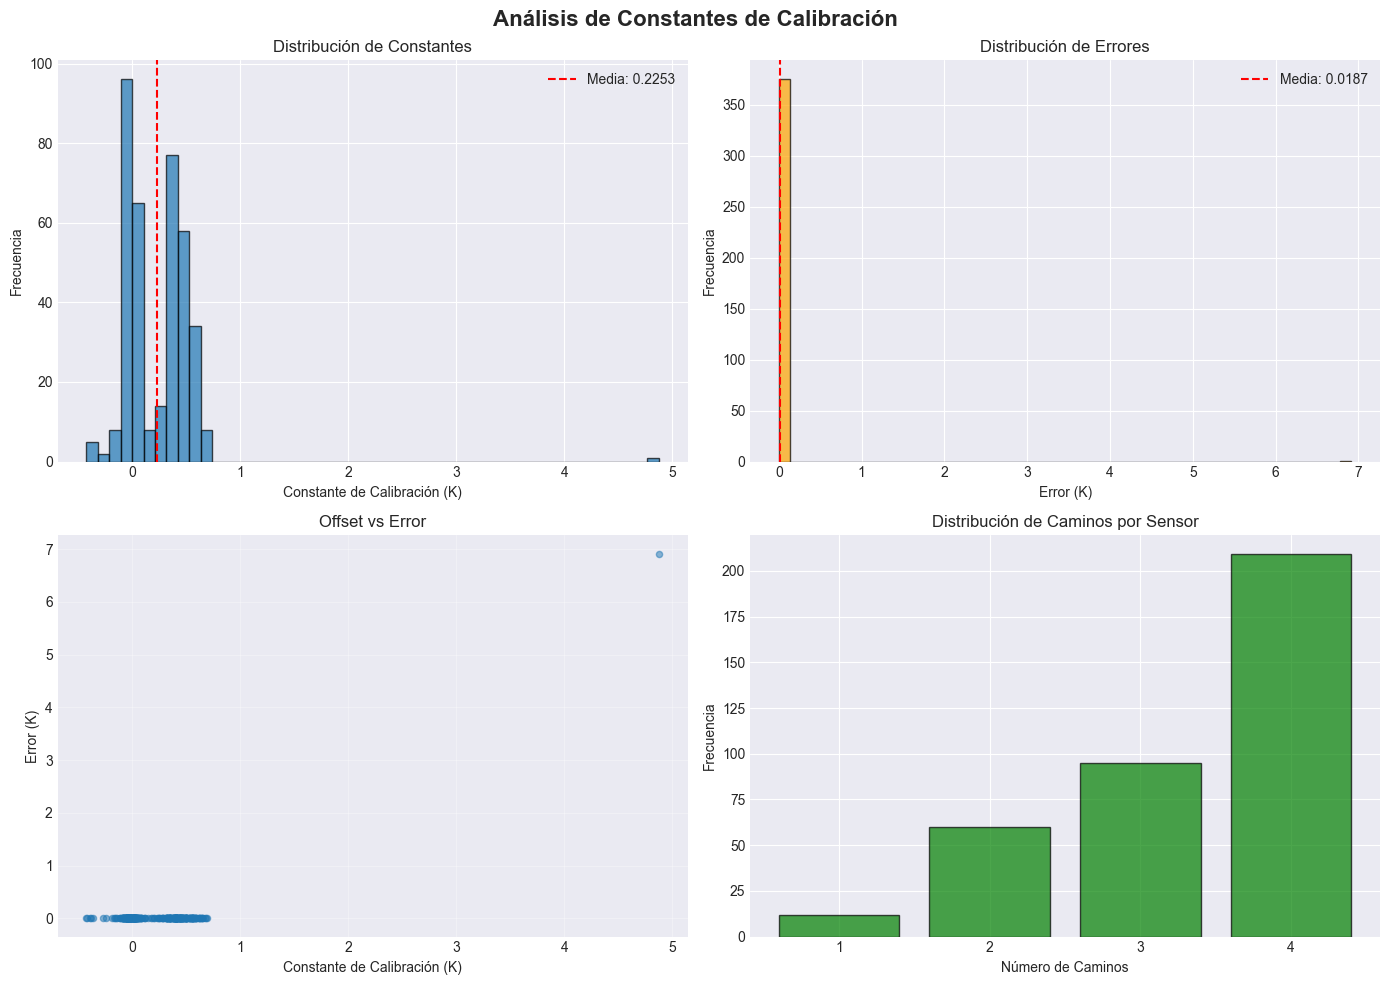

✓ Gráficos generados


In [9]:
# Configurar gráficos
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis de Constantes de Calibración', fontsize=16, fontweight='bold')

# 1. Histograma de offsets
axes[0, 0].hist(calculated['Constante_Calibracion_K'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Constante de Calibración (K)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución de Constantes')
axes[0, 0].axvline(calculated['Constante_Calibracion_K'].mean(), 
                   color='red', linestyle='--', label=f'Media: {calculated["Constante_Calibracion_K"].mean():.4f}')
axes[0, 0].legend()

# 2. Histograma de errores
axes[0, 1].hist(calculated['Error_K'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Error (K)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de Errores')
axes[0, 1].axvline(calculated['Error_K'].mean(), 
                   color='red', linestyle='--', label=f'Media: {calculated["Error_K"].mean():.4f}')
axes[0, 1].legend()

# 3. Offset vs Error
axes[1, 0].scatter(calculated['Constante_Calibracion_K'], calculated['Error_K'], 
                   alpha=0.5, s=20)
axes[1, 0].set_xlabel('Constante de Calibración (K)')
axes[1, 0].set_ylabel('Error (K)')
axes[1, 0].set_title('Offset vs Error')
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribución de N_Paths
path_counts = calculated['N_Paths'].value_counts().sort_index()
axes[1, 1].bar(path_counts.index, path_counts.values, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].set_xlabel('Número de Caminos')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Caminos por Sensor')
axes[1, 1].set_xticks(path_counts.index)

plt.tight_layout()
plt.show()

print("✓ Gráficos generados")

## 9. Comparación por Sets

Estadísticas por Set:
      N_Sensors  Offset_Mean  Offset_Std  Error_Mean  Error_Std  Paths_Mean
Set                                                                        
3.0          10    -0.065539    0.032199    0.000217   0.000041    3.600000
4.0          10    -0.020692    0.040621    0.000294   0.000071    2.700000
5.0          11    -0.038852    0.029404    0.000270   0.000045    3.636364
6.0          10    -0.016908    0.070542    0.000292   0.000060    2.700000
7.0           9    -0.027949    0.032543    0.000244   0.000043    3.555556
8.0          10    -0.034658    0.033274    0.000253   0.000042    3.600000
9.0          12     0.106719    0.069313    0.000197   0.000034    3.666667
10.0         12     0.135043    0.267805    0.000269   0.000054    2.750000
11.0         12     0.130122    0.229725    0.000229   0.000037    3.666667
13.0         12     0.227593    0.281148    0.000231   0.000038    3.666667


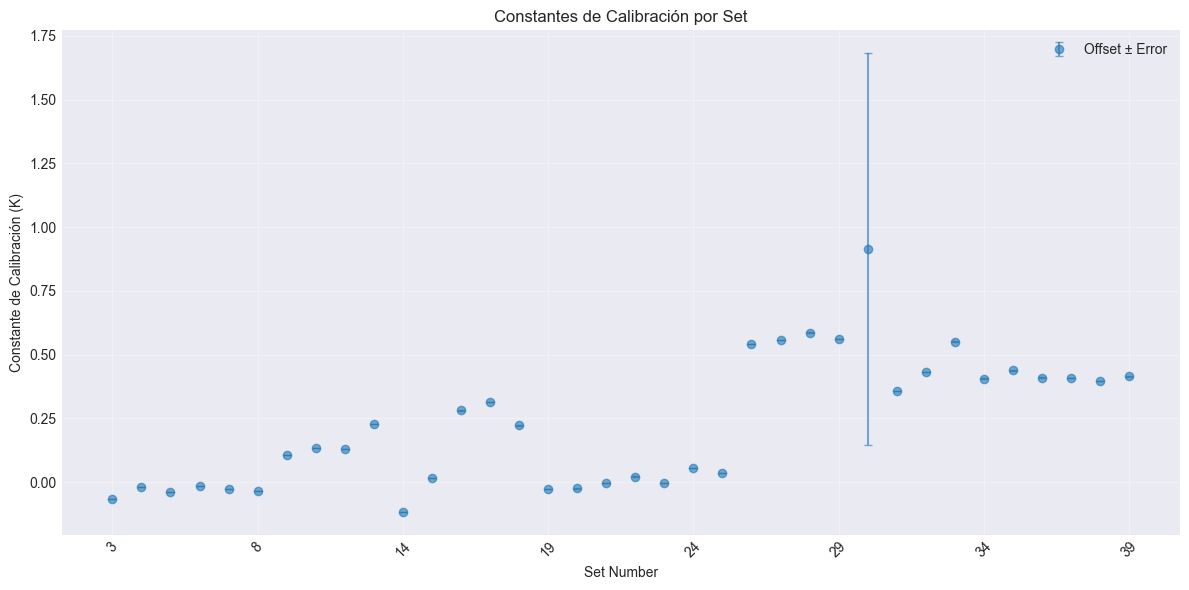

In [10]:
# Agrupar por set
set_stats = calculated.groupby('Set').agg({
    'Sensor': 'count',
    'Constante_Calibracion_K': ['mean', 'std'],
    'Error_K': ['mean', 'std'],
    'N_Paths': 'mean'
}).round(6)

set_stats.columns = ['N_Sensors', 'Offset_Mean', 'Offset_Std', 'Error_Mean', 'Error_Std', 'Paths_Mean']

print("Estadísticas por Set:")
print("=" * 100)
print(set_stats.head(10))

# Visualizar
fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(set_stats))
ax.errorbar(x, set_stats['Offset_Mean'], yerr=set_stats['Error_Mean'], 
            fmt='o', alpha=0.6, capsize=3, label='Offset ± Error')
ax.set_xlabel('Set Number')
ax.set_ylabel('Constante de Calibración (K)')
ax.set_title('Constantes de Calibración por Set')
ax.set_xticks(x[::5])  # Mostrar cada 5 sets
ax.set_xticklabels([f"{s:.0f}" for s in set_stats.index[::5]], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Validación: Sensores con Múltiples Caminos

Los sensores con más caminos deberían tener menor error.

In [11]:
# Agrupar por número de caminos
path_analysis = calculated.groupby('N_Paths').agg({
    'Sensor': 'count',
    'Error_K': ['mean', 'std', 'min', 'max']
}).round(6)

path_analysis.columns = ['N_Sensors', 'Error_Mean', 'Error_Std', 'Error_Min', 'Error_Max']

print("Análisis: Error vs Número de Caminos")
print("=" * 70)
print(path_analysis)

print("\nHipótesis: A más caminos, menor error promedio")
if len(path_analysis) > 1:
    correlation = calculated[['N_Paths', 'Error_K']].corr().iloc[0, 1]
    print(f"Correlación N_Paths vs Error: {correlation:.3f}")
    
    if correlation < -0.3:
        print("✓ Hipótesis CONFIRMADA: Más caminos → Menor error")
    elif correlation > 0.3:
        print("✗ Hipótesis RECHAZADA: Más caminos → Mayor error")
    else:
        print("~ Correlación DÉBIL: Efecto no concluyente")

Análisis: Error vs Número de Caminos
         N_Sensors  Error_Mean  Error_Std  Error_Min  Error_Max
N_Paths                                                        
1               12    0.000464   0.000026   0.000419   0.000494
2               60    0.000326   0.000035   0.000242   0.000423
3               95    0.073060   0.709491   0.000223   6.915528
4              209    0.000229   0.000026   0.000162   0.000304

Hipótesis: A más caminos, menor error promedio
Correlación N_Paths vs Error: -0.020
~ Correlación DÉBIL: Efecto no concluyente


## 11. Exportar Resultados Completos

In [12]:
# CSV ya fue exportado en calibrate_tree()
print(f"✓ CSV exportado: {output_path}")
print(f"  Filas: {len(df_constants)}")
print(f"  Columnas: {list(df_constants.columns)}")

# Exportar también estadísticas por set
stats_path = project_root / 'data' / 'results' / 'calibration_stats_by_set.csv'
set_stats.to_csv(stats_path)
print(f"\n✓ Estadísticas por set: {stats_path}")

✓ CSV exportado: /Users/vicky/Desktop/rtd-calib-desde0/RTD_Calibration/data/results/calibration_constants_tree.csv
  Filas: 433
  Columnas: ['Sensor', 'Set', 'Round', 'Constante_Calibracion_K', 'Error_K', 'N_Paths', 'Status']

✓ Estadísticas por set: /Users/vicky/Desktop/rtd-calib-desde0/RTD_Calibration/data/results/calibration_stats_by_set.csv


## 12. Resumen Final

### Proceso completado:

1. ✅ Carga de configuración y creación de CalibSets
2. ✅ Construcción del Tree con jerarquía R3 → R2 → R1
3. ✅ Cálculo de offsets_to_raised para cada TreeEntry
4. ✅ Búsqueda de múltiples caminos R1 → R3
5. ✅ Media ponderada usando 1/σ²
6. ✅ Constantes finales para todos los sensores
7. ✅ Exportación a CSV

### Ventajas del método multicamino:

- **Redundancia**: Múltiples caminos independientes
- **Precisión mejorada**: Media ponderada reduce error
- **Robustez**: Si un camino falla, hay otros disponibles
- **Trazabilidad**: Cada camino está documentado

### Archivos generados:

- `calibration_constants_tree.csv`: Constantes finales
- `calibration_stats_by_set.csv`: Estadísticas por set

In [13]:
print("\n" + "=" * 70)
print("✓ Notebook TREE_CALIBRATION completado")
print("=" * 70)
print("\nArchivos generados:")
print(f"  {output_path}")
print(f"  {stats_path}")
print("\nPróximos pasos:")
print("  - Comparar con métodos anteriores")
print("  - Integrar en main.py")
print("  - Validar con datos reales")


✓ Notebook TREE_CALIBRATION completado

Archivos generados:
  /Users/vicky/Desktop/rtd-calib-desde0/RTD_Calibration/data/results/calibration_constants_tree.csv
  /Users/vicky/Desktop/rtd-calib-desde0/RTD_Calibration/data/results/calibration_stats_by_set.csv

Próximos pasos:
  - Comparar con métodos anteriores
  - Integrar en main.py
  - Validar con datos reales
